# Data cleaning and exploration

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import chisquare
from scipy.stats import pearsonr
import seaborn as sns

In [ ]:
drugs= pd.read_csv('saleshourly.csv')

## The data

In [ ]:
drugs.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014 8:00,0.0,0.67,0.4,2.0,0.0,0.0,0.0,1.0,2014,1,8,Thursday
1,1/2/2014 9:00,0.0,0.00,1.0,0.0,2.0,0.0,0.0,0.0,2014,1,9,Thursday
2,1/2/2014 10:00,0.0,0.00,0.0,3.0,2.0,0.0,0.0,0.0,2014,1,10,Thursday
3,1/2/2014 11:00,0.0,0.00,0.0,2.0,1.0,0.0,0.0,0.0,2014,1,11,Thursday
4,1/2/2014 12:00,0.0,2.00,0.0,5.0,2.0,0.0,0.0,0.0,2014,1,12,Thursday


We found that the float that we have in the sold column for each drug is based on a strip of pills where the size of that strip is not recorded, nor is the dosage of the drug. Thus we cannot make comparisons of scaled size of the sales of single drug versus another (we cannot say drug A sells twice as well as drug B). Instead, we must compare them normalized and only in the sense of coorilation between the sales. If we do an analysis between drugs of that nature, we will normalize each column to sum to a constant that is the same for every drug.

One other surprise was that this dataset doesn't list the number of purchases within each time frame. It only lists the amount of each drug type sold each hour. This means that we can't look at the number of drug purchases across time. We can only look at the amount of drug purchased over time.

## Check for missing data

In [ ]:
#Check for empty strings 
empty = np.array([(drugs[col].astype(str).unique() == '').any() for col in drugs.columns.tolist()])
print("Any empty strings: " + str((empty == True).any()))

#Check for any missing data
print('\nAny missing data (by column):')
display(drugs.isnull().any())

Any empty strings: False

Any missing data (by column):


datum           False
M01AB           False
M01AE           False
N02BA           False
N02BE           False
N05B            False
N05C            False
R03             False
R06             False
Year            False
Month           False
Hour            False
Weekday Name    False
dtype: bool

From the cell above we see that there is no missing data in any of the columns. We were also careful to check if there were any empty strings since those values are still missing but will not show up by calling df.isnull(). In terms of any columns we can drop, we technically could drop the columns Year, Month, Hour, and Weekday Name. However, we will keep these columns for convenience.

## Get distribution of values in each of the drug columns for hourly data

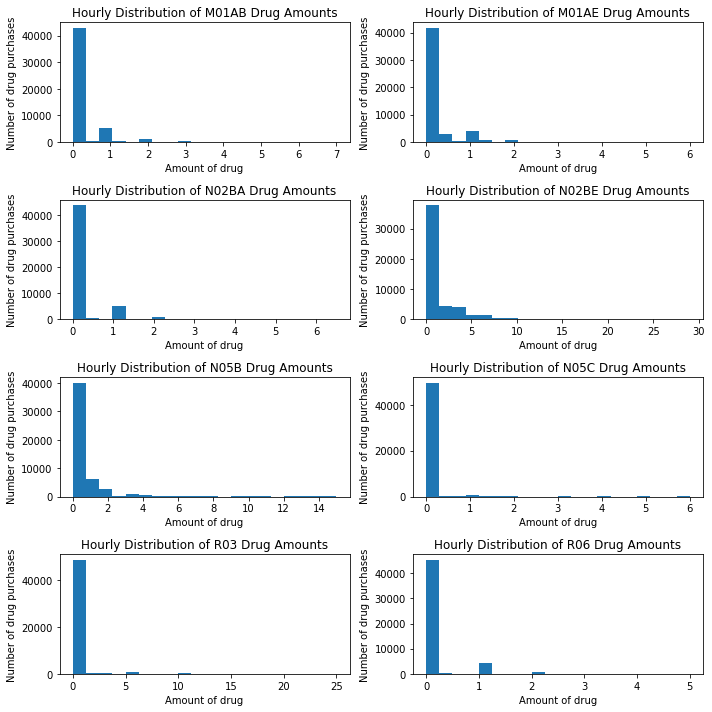

In [ ]:
# Get list of drugs
drug_list = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']
plt.figure(figsize=(10,10))

# Create plot
for i,drug in enumerate(drug_list):
  plt.subplot(4,2,i+1)
  plt.hist(drugs[drug], bins=20)
  plt.title('Hourly Distribution of ' + drug + ' Drug Amounts')
  plt.ylabel('Number of drug purchases')
  plt.xlabel('Amount of drug')

# Show plot
plt.tight_layout()
plt.show()

The outliers in these graphs represent hours when a lot of a certain drug category was purchase. Most hours contain no drug purchases for a certain type of drug. We think that it is very unlikely that most of these outliers are due to human error or machine malfunction because drug purchases are tracked very well and recording the purchases is pretty straight forward

## Pearson correlation between drug sales

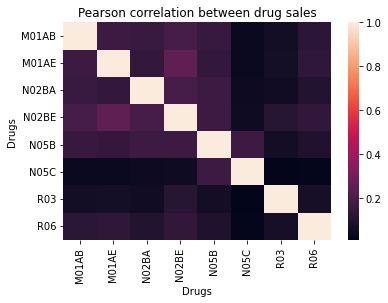

In [ ]:
# Set initial variables
n = len(drug_list)
correlation = pd.DataFrame(columns=drug_list, index=drug_list)

# Get correlation between drug sales
for drug in drug_list:
  for drug_2 in drug_list:
    correlation.loc[drug,drug_2] = float(pearsonr(drugs[drug], drugs[drug_2])[0])

# Create plot
correlation = correlation.astype('float')
sns.heatmap(correlation)
plt.xlabel('Drugs')
plt.ylabel('Drugs')
plt.title('Pearson correlation between drug sales')
plt.show()

This graph shows that most drug pairs don't have a very high pearson correlation score for hourly sales. 

## Drug sales by day of the week

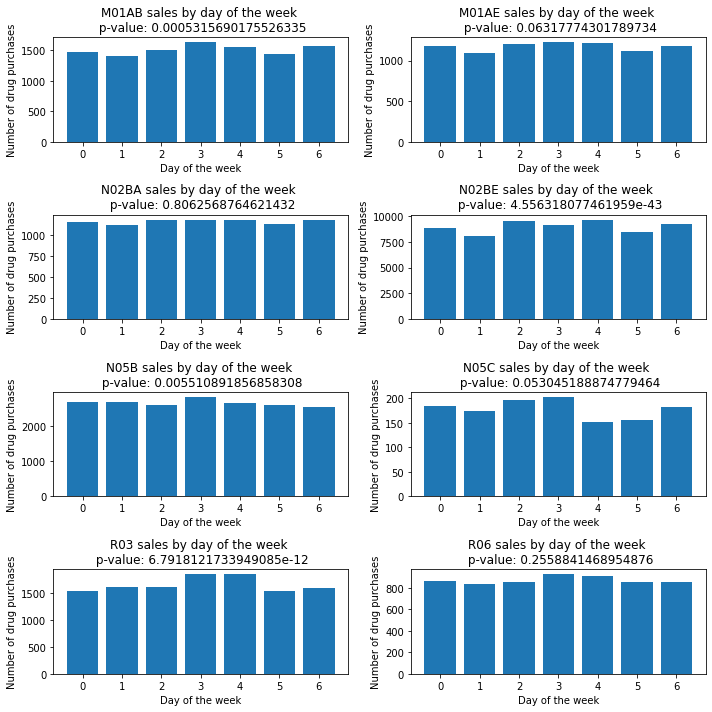

In [ ]:
# Set initial variables
drug_list = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']
plt.figure(figsize=(10,10))

# Get drug sales by week
for i,drug in enumerate(drug_list):
    plt.subplot(4,2,i+1)
    bar_nums = [sum(drugs[drug][i::7]) for i in range(7)]
    expected = sum(bar_nums)/7
    p = chisquare(bar_nums, expected)[1]
    plt.bar(range(7), bar_nums)
    plt.title(drug + ' sales by day of the week \n p-value: ' + str(p))
    plt.ylabel('Number of drug purchases')
    plt.xlabel('Day of the week')

# Show plot
plt.tight_layout()
plt.show()

The p-values in these graphs come from the chi-squared test. This test compares the distribution of sales across days of the week to the uniform distribution. If our significance value is 0.05, and we use bonferonni correction method (meaning our significance level becomes 0.00625), we see that the p-values for 4 of these graphs are significant. This suggests that assuming that drug sales are uniformly distributed across the days of the week for M01AB, N02BE, N05B, and R03 doesn't provide us with the whole picture. Thus drug purchases may not be completely independent of purchase day. 

# Drug sales by month

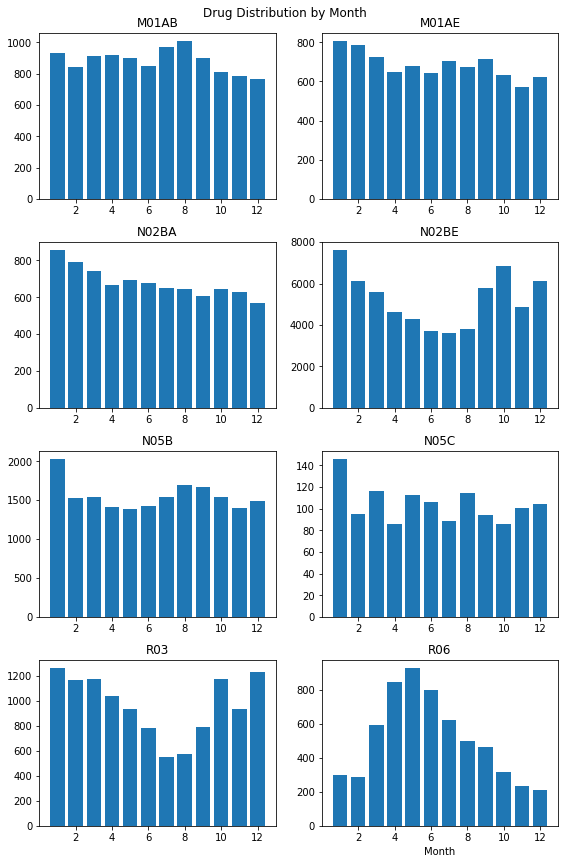

In [ ]:
# Group drug sales by month
gb_month = drugs.groupby(by=['Month']).sum(numeric_only=True)

# Set plot variables
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(8, 12)

# Create plot
for i, drug in enumerate(drug_list):
    ax[int(np.floor(i/2))][i%2].bar(gb_month.index, gb_month[drug])
    ax[int(np.floor(i/2))][i%2].set_title(drug)

# Show plot  
fig.tight_layout()
fig.suptitle('Drug Distribution by Month')
fig.subplots_adjust(top=0.95)
plt.xlabel('Month')
plt.show()

Many of these graphs appear to have a pattern to the months that the drugs are purchased in. For example R03 drugs are purchased less during the summer months and R06 drugs are purchased more during the summer months. This suggests that drug purchases may not be independent of the month that they are purchased in. 

## Pearson correlation for monthly drug sales

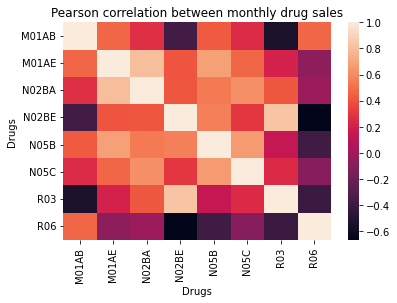

In [ ]:
# Set initial variables
n = len(drug_list)
correlation = pd.DataFrame(columns=drug_list, index=drug_list)

# Get correlation between drug sales
for drug in drug_list:
  for drug_2 in drug_list:
    correlation.loc[drug,drug_2] = float(pearsonr(gb_month[drug], gb_month[drug_2])[0])

# Create plot
correlation = correlation.astype('float')
sns.heatmap(correlation)
plt.xlabel('Drugs')
plt.ylabel('Drugs')
plt.title('Pearson correlation between monthly drug sales')
plt.show()

This graph shows that the Pearson correlation between drug sales grouped by month is often higher than hourly drug sales. For example the drugs N02BE and R03 appear to have highly correlated monthly sales. 

# Drug sales by year

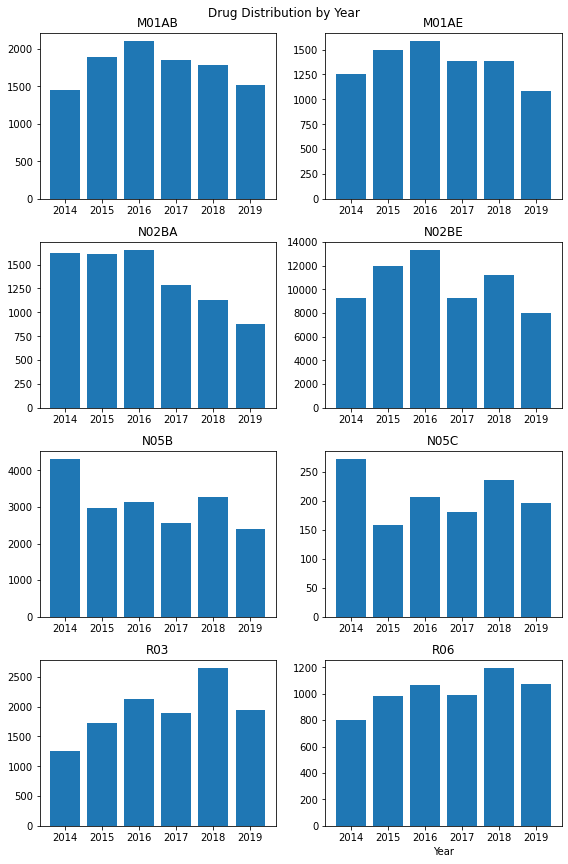

In [ ]:
# Group sales by year
gb_year = drugs.groupby(by=['Year']).sum(numeric_only=True)

# Set variables for plot
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(8, 12)

# Create plot
for i, drug in enumerate(drug_list):
    ax[int(np.floor(i/2))][i%2].bar(gb_year.index, gb_year[drug])
    ax[int(np.floor(i/2))][i%2].set_title(drug)

# Show plot    
fig.tight_layout()
fig.suptitle('Drug Distribution by Year')
plt.xlabel('Year')
fig.subplots_adjust(top=0.95)
plt.show()

## Pearson correlation for yearly drug sales

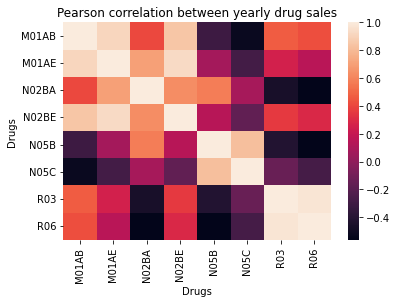

In [ ]:
# Set initial variables
n = len(drug_list)
correlation = pd.DataFrame(columns=drug_list, index=drug_list)

# Get correlation between drug sales
for drug in drug_list:
  for drug_2 in drug_list:
    correlation.loc[drug,drug_2] = float(pearsonr(gb_year[drug], gb_year[drug_2])[0])

# Create plot
correlation = correlation.astype('float')
sns.heatmap(correlation)
plt.xlabel('Drugs')
plt.ylabel('Drugs')
plt.title('Pearson correlation between yearly drug sales')
plt.show()

This graph gives similar results to the graph for monthly drug sales. We see that drug sales grouped by year for several drug pairs are very highly correlated. This again potentially raises a problem with treating the data as completely independent.

# Correlation between drug pairs

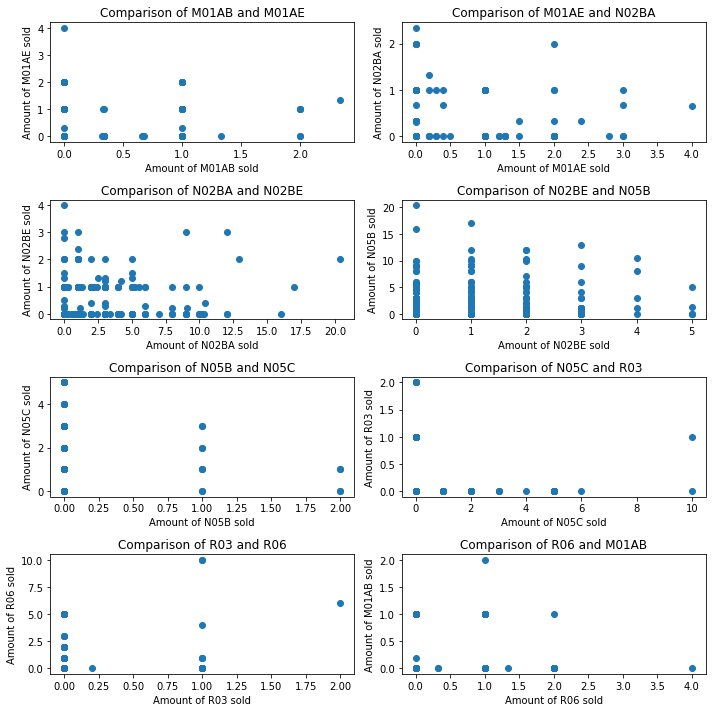

In [ ]:
# Set initial variables
drug_list = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']
plt.figure(figsize=(10,10))

# Compare drugs 
for i,drug in enumerate(drug_list):
  plt.subplot(4,2,i+1)
  plt.scatter(drugs[drug_list[(i+1)%8]][:500],drugs[drug][:500])
  plt.title('Comparison of ' + drug + ' and ' + drug_list[(i+1)%8])
  plt.ylabel('Amount of ' + drug_list[(i+1)%8] + ' sold')
  plt.xlabel('Amount of ' + drug +  ' sold')

# Show plot
plt.tight_layout()
plt.show()

## Conclusion

We will do an 80/20 train/test split on the data by using the last 20% of the dataset as our test set. The yearly drug sales plots show that drug sales are variable from year to year, so we will have to be aware that our test set might not be from the same distribution as our training set. 

We are concerned that we may not be able to use HMM's because each step in the HMM only depends on the previous step. Our drug sale data doesn't seem to only depend on the previous day/hour/week etc. However we think that HMMs might still be informative for our project if we use several steps back instead of only one step back. From our analysis here it seems like we will probably be able to use most of the methods we originally suggested, but we will have to be careful about the independence of our data. This is something we will have to keep in mind as we do our analysis. We may have to remove some of our samples to make the dataset more independent. 